## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
# !{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
# import gdown
# url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
# output = "IT_data.h5"
# gdown.download(url, output, quiet=False, fuzzy=True)

In [3]:
# What model you want to use?
my_model = "pretrained"
# my_model = "random"

# Have you already obtained the primary components?
# need_to_extract_pca = "False"
need_to_extract_pca = "True"

### Load the data

In [4]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

In [5]:
y_train = spikes_train
y_val = spikes_val

In [6]:
stimulus_train.shape

(2592, 3, 224, 224)

In [7]:
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import gc
import pickle

In [8]:
# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA available: Yes")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA available: No")


PyTorch version: 2.7.0+cu118
CUDA available: Yes
CUDA version: 11.8
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce RTX 4090 Laptop GPU


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
model_name = "resnet50"
resnet50 = getattr(models, model_name)(weights='IMAGENET1K_V1')

In [11]:
len(y_train[0])

168

In [12]:
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, len(y_train[0]))  

resnet50.eval()  # Set to evaluation mode
resnet50 = resnet50.to(device)

In [13]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

In [14]:
# Define batch size
batch_size = 128

# Create training dataset and dataloader
train_dataset = TensorDataset(
    preprocess_images(stimulus_train), 
    torch.tensor(y_train, dtype=torch.float32)
)
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)

# Create evaluation dataset and dataloader
eval_dataset = TensorDataset(
    preprocess_images(stimulus_val), 
    torch.tensor(y_val, dtype=torch.float32)
)
eval_dataloader = DataLoader(
    eval_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

In [15]:
criterion = nn.MSELoss()

In [16]:
import torch.optim as optim
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

In [17]:
num_epochs = 1000

In [48]:
def train_model(model, train_dataloader, eval_dataloader, y_train, y_val, criterion, 
                num_epochs, device, warmup_epochs=2, lr_start=0.0001, lr_max=0.001, lr_min=0.00001,
                patience=50, min_delta=0.001):
    # Lists to store metrics
    train_losses = []
    val_accuracies = []
    
    # Initialize optimizer with starting learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_start)
    
    # Early stopping variables
    best_val_mse = float('inf')
    counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        # Adjust learning rate based on epoch
        if epoch < warmup_epochs:
            # Linear warmup
            lr = lr_start + (lr_max - lr_start) * epoch / warmup_epochs
        else:
            # Cosine annealing after warmup
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            lr = lr_min + 0.5 * (lr_max - lr_min) * (1 + math.cos(math.pi * progress))
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        
        # Evaluation phase
        model.eval()
        
        with torch.no_grad():
            all_preds = []
            total_mse = 0.0
            num_batches = 0
            
            for inputs, targets in eval_dataloader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate MSE
                batch_mse = criterion(outputs, targets).item()
                total_mse += batch_mse
                num_batches += 1
                
                # Store predictions for further analysis if needed
                all_preds.append(outputs.cpu().numpy())
                
        # Calculate average MSE over all validation batches
        val_mse = total_mse / num_batches
        val_accuracies.append(-val_mse)  # Store negative MSE so higher is better in plots
        
        print(f'Epoch {epoch+1}/{num_epochs}, LR: {lr:.6f}, Loss: {epoch_loss:.4f}, Validation MSE: {val_mse:.4f}')
        
        # Early stopping check
        if val_mse < best_val_mse - min_delta:
            best_val_mse = val_mse
            counter = 0
            # Save the best model state
            best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                # Load the best model state
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
    
    return train_losses, val_accuracies


In [51]:
# Import math for cosine annealing
import math

# Train the model
train_losses, val_accuracies = train_model(
    model=resnet50,
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    y_train=y_train,
    y_val=y_val,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    patience=100
)

Epoch 1/1000, LR: 0.000100, Loss: 0.0438, Validation MSE: 0.0614
Epoch 2/1000, LR: 0.000550, Loss: 0.0429, Validation MSE: 0.0733
Epoch 3/1000, LR: 0.001000, Loss: 0.0460, Validation MSE: 0.0743
Epoch 4/1000, LR: 0.001000, Loss: 0.0465, Validation MSE: 0.0890
Epoch 5/1000, LR: 0.001000, Loss: 0.0430, Validation MSE: 0.0684
Epoch 6/1000, LR: 0.001000, Loss: 0.0382, Validation MSE: 0.0716
Epoch 7/1000, LR: 0.001000, Loss: 0.0348, Validation MSE: 0.0708
Epoch 8/1000, LR: 0.001000, Loss: 0.0321, Validation MSE: 0.0649
Epoch 9/1000, LR: 0.001000, Loss: 0.0293, Validation MSE: 0.0681
Epoch 10/1000, LR: 0.001000, Loss: 0.0280, Validation MSE: 0.0647
Epoch 11/1000, LR: 0.001000, Loss: 0.0263, Validation MSE: 0.0686
Epoch 12/1000, LR: 0.001000, Loss: 0.0249, Validation MSE: 0.0669
Epoch 13/1000, LR: 0.001000, Loss: 0.0230, Validation MSE: 0.0698
Epoch 14/1000, LR: 0.001000, Loss: 0.0224, Validation MSE: 0.0689
Epoch 15/1000, LR: 0.001000, Loss: 0.0207, Validation MSE: 0.0664
Epoch 16/1000, LR: 

In [63]:
# Save the trained model
torch.save(resnet50.state_dict(), 'resnet50_fpft.pth')
print("Model saved successfully to 'resnet50_fpft.pth'")

Model saved successfully to 'resnet50_fpft.pth'


In [18]:
# Load the trained model
model_path = 'resnet50_fpft.pth'
resnet50.load_state_dict(torch.load(model_path))
resnet50.eval()  # Set the model to evaluation mode
print(f"Model loaded successfully from '{model_path}'")

Model loaded successfully from 'resnet50_fpft.pth'


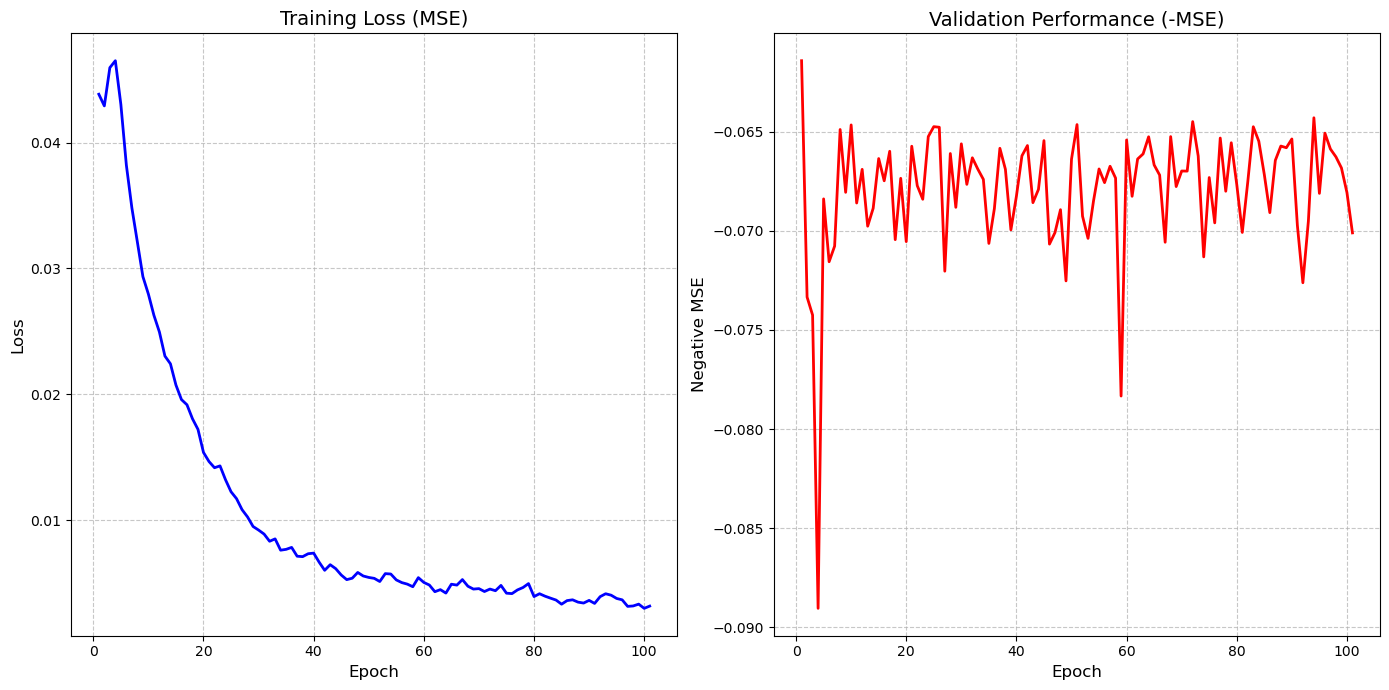

In [53]:
# Plot training loss and validation accuracy
plt.figure(figsize=(14, 7))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', linewidth=2)
plt.title('Training Loss (MSE)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot validation accuracy (negative MSE)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, 'r-', linewidth=2)
plt.title('Validation Performance (-MSE)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Negative MSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Set model type for later use
my_model = "pretrained"

In [60]:
def evaluate_model(model, eval_dataloader, y_val, device):
    model.eval()  # Set to evaluation mode
    
    all_predictions = []
    
    with torch.no_grad():
        for batch in eval_dataloader:
            if isinstance(batch, list):
                # If it's a list, assume the first element is the input
                inputs = batch[0]
            elif isinstance(batch, tuple):
                inputs = batch[0]
            else:
                inputs = batch
            
            if not isinstance(inputs, torch.Tensor):
                inputs = torch.tensor(inputs, dtype=torch.float32)
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            all_predictions.append(outputs.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    
    # Ensure predictions and ground truth have the same number of samples
    if predictions.shape[0] > y_val.shape[0]:
        predictions = predictions[:y_val.shape[0]]
    elif predictions.shape[0] < y_val.shape[0]:
        y_val = y_val[:predictions.shape[0]]
    
    # Calculate correlation and explained variance for each neuron
    correlations = []
    exp_variances = []
    
    for neuron in range(y_val.shape[1]):
        y_true = y_val[:, neuron]
        y_pred = predictions[:, neuron]
        
        # Calculate correlation
        correlation = np.corrcoef(y_pred, y_true)[0, 1]
        correlations.append(correlation)
        
        # Calculate explained variance
        exp_var = explained_variance_score(y_true, y_pred)
        exp_variances.append(exp_var)
    
    # Calculate averages
    mean_correlation = np.mean(correlations)
    mean_exp_variance = np.mean(exp_variances)
    
    print(f"Mean correlation: {mean_correlation:.4f}")
    print(f"Mean explained variance: {mean_exp_variance:.4f}")
    
    # Visualize overall results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Plot correlations without sorting
    plt.plot(range(len(correlations)), correlations, 'o-', markersize=3)
    plt.axhline(mean_correlation, color='r', linestyle='--')
    plt.title(f'Correlation Distribution (Mean: {mean_correlation:.4f})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Correlation')
    
    plt.subplot(1, 2, 2)
    # Plot explained variances without sorting
    plt.plot(range(len(exp_variances)), exp_variances, 'o-', markersize=3)
    plt.axhline(mean_exp_variance, color='r', linestyle='--')
    plt.title(f'Explained Variance Distribution (Mean: {mean_exp_variance:.4f})')
    plt.xlabel('Neuron Index')
    plt.ylabel('Explained Variance')
    
    plt.tight_layout()
    plt.show()
    
    return predictions, correlations, exp_variances, mean_correlation, mean_exp_variance

Mean correlation: 0.6863
Mean explained variance: 0.4861


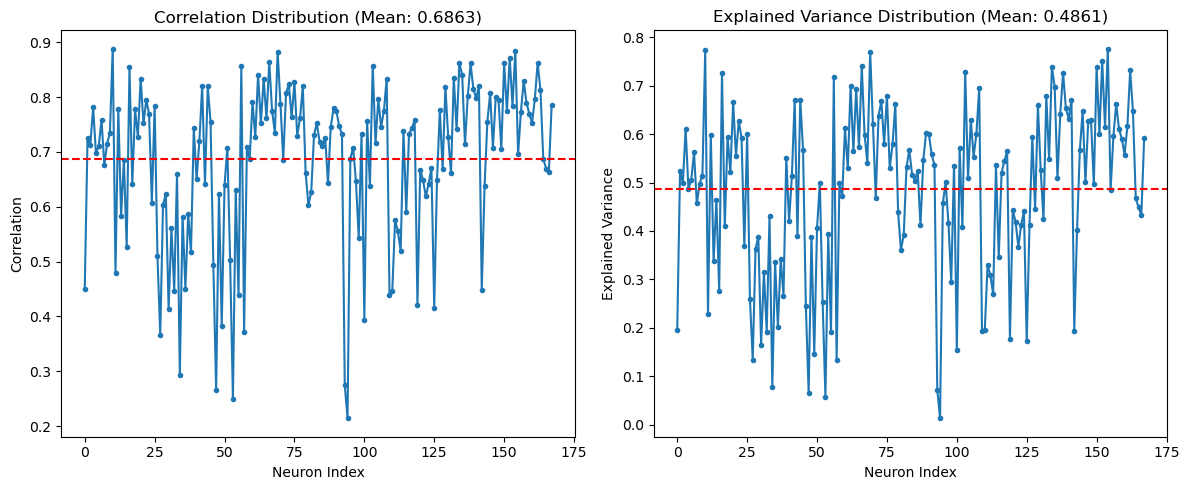

In [ ]:
predictions, correlations, exp_variances, mean_correlation, mean_exp_variance = evaluate_model(
    model=resnet50,         
    eval_dataloader=eval_dataloader,  
    y_val=y_val,          
    device=device       
)

# 2 Now use the fine tuned model and do like task-driven approach

In [19]:
import torch
from torch import nn
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import gc
import pickle

In [21]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, layers):
        super(FeatureExtractor, self).__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}
        
        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.get_hook(layer_id))
    
    def get_hook(self, layer_id):
        def hook(module, input, output):
            self._features[layer_id] = output
        return hook
    
    def forward(self, x):
        self.model(x)
        return [self._features[layer_id] for layer_id in self.layers]

In [23]:
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [22]:
layers_to_extract = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']

In [24]:
# Convert HxWxC numpy images to CxHxW torch tensors
def preprocess_images(images):
    # Images are already normalized in the dataset
    # Convert to torch tensor and adjust dimensions
    images_tensor = torch.tensor(images, dtype=torch.float32)
    # Our images are already in the format [batch, channels, height, width]
    return images_tensor

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
def extract_features(model, stimulus, batch_size=128):
    # Create feature extractor
    extractor = FeatureExtractor(model, layers_to_extract)
    extractor.to(device)
    extractor.eval()
    
    results = {}
    
    # Process one layer at a time
    for layer_name in layers_to_extract:
        print(f"\nProcessing layer: {layer_name}")
        
        # Create DataLoader
        dataset = TensorDataset(preprocess_images(stimulus))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
        # Collect activations
        layer_activations = []
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Extracting {layer_name}"):
                batch = batch[0].to(device)
                # Call the entire model to get all activations
                activations = extractor(batch)
                # Find the index of the current layer
                layer_idx = layers_to_extract.index(layer_name)
                # Get activations for the current layer
                layer_act = activations[layer_idx].cpu().numpy()
                
                # Flatten
                if len(layer_act.shape) > 2:
                    layer_act = layer_act.reshape(layer_act.shape[0], -1)
                
                layer_activations.append(layer_act)
        
        # Combine batches
        layer_act = np.vstack(layer_activations)
        
        # Store original features
        results[layer_name] = {
            'features': layer_act
        }
        
        # ===============
        # clean up memory
        del layer_activations, layer_act
        gc.collect()
        torch.cuda.empty_cache()
    
    # Clean up extractor
    del extractor
    gc.collect()
    torch.cuda.empty_cache()
    
    return results

In [27]:
def apply_pca_to_features(train_features, val_features, n_components=1000):
    train_pcs = {}
    val_pcs = {}
    
    for layer_name in layers_to_extract:
        X_train = train_features[layer_name]['features']
        X_val = val_features[layer_name]['features']
        
        # If n_components is greater than or equal to the feature dimensions, skip PCA
        if n_components >= X_train.shape[1]:
            print(f"Layer {layer_name}: Skipping PCA as n_components ({n_components}) >= feature dimensions ({X_train.shape[1]})")
            train_pcs[layer_name] = {
                'pcs': X_train,
                'scaler': None,
                'pca': None
            }
            val_pcs[layer_name] = {
                'pcs': X_val
            }
            continue
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val) 
        
        n_comp = min(n_components, X_train.shape[0], X_train.shape[1])
        pca = PCA(n_components=n_comp)
        train_pcs[layer_name] = {
            'pcs': pca.fit_transform(X_train_scaled),
            'scaler': scaler,
            'pca': pca
        }
        
        val_pcs[layer_name] = {
            'pcs': pca.transform(X_val_scaled)
        }
        
        print(f"Layer {layer_name}: {n_comp} components, {sum(pca.explained_variance_ratio_):.4f} variance explained")
    
    return train_pcs, val_pcs

In [29]:
features_train = extract_features(resnet50, stimulus_train)
features_val = extract_features(resnet50, stimulus_val)


Processing layer: conv1


Extracting conv1: 100%|██████████| 21/21 [00:06<00:00,  3.37it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 21/21 [00:06<00:00,  3.25it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 21/21 [00:04<00:00,  4.30it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 21/21 [00:04<00:00,  5.13it/s]



Processing layer: avgpool


Extracting avgpool: 100%|██████████| 21/21 [00:03<00:00,  5.48it/s]



Processing layer: conv1


Extracting conv1: 100%|██████████| 3/3 [00:00<00:00,  4.42it/s]



Processing layer: layer1


Extracting layer1: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]



Processing layer: layer2


Extracting layer2: 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]



Processing layer: layer3


Extracting layer3: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]



Processing layer: layer4


Extracting layer4: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s]



Processing layer: avgpool


Extracting avgpool: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


In [30]:
pretrained_pcs_train, pretrained_pcs_val = apply_pca_to_features(
            features_train, 
            features_val, 
            n_components=1000
        )

Layer conv1: 1000 components, 0.8587 variance explained
Layer layer1: 1000 components, 0.7541 variance explained
Layer layer2: 1000 components, 0.7153 variance explained
Layer layer3: 1000 components, 0.6992 variance explained
Layer layer4: 1000 components, 0.8563 variance explained
Layer avgpool: 1000 components, 0.9975 variance explained


In [31]:
print("Saving PCA results...")
with open('fpft_pretrained_pcs.pkl', 'wb') as f:
    pickle.dump((pretrained_pcs_train, pretrained_pcs_val), f)

Saving PCA results...


In [32]:
print("Loading PCA results...")
with open('fpft_pretrained_pcs.pkl', 'rb') as f:
    pretrained_pcs_train, pretrained_pcs_val = pickle.load(f)

Loading PCA results...


In [33]:
from sklearn.linear_model import Ridge

def predict_neural_activity(layer_pcs_train, layer_pcs_val, y_train, y_val, regressor="Linear", alpha=1.0, sample_to_plot=0):
    layer_metrics = {}
    sample_predictions = {}
    
    for layer_name in layers_to_extract:
        print(f"Predicting neural activity using {layer_name}")
        X_train_pcs = layer_pcs_train[layer_name]['pcs']
        X_val_pcs = layer_pcs_val[layer_name]['pcs']
        

        if X_train_pcs.shape[1] != X_val_pcs.shape[1]:
            print(f"Warning: Feature mismatch for {layer_name}. Training: {X_train_pcs.shape[1]}, Validation: {X_val_pcs.shape[1]}")
            min_components = min(X_train_pcs.shape[1], X_val_pcs.shape[1])
            X_train_pcs = X_train_pcs[:, :min_components]
            X_val_pcs = X_val_pcs[:, :min_components]
            print(f"Using {min_components} components for both sets")
        
        correlations = []
        exp_variances = []
        sample_neuron_predictions = []  # Store predictions for all neurons for a specific sample
        
        for neuron in tqdm(range(y_train.shape[1]), desc=f"Training models for {layer_name}"):
            # Choose regressor based on parameter
            if regressor == "Linear":
                lr = LinearRegression()
            elif regressor == "Ridge":
                lr = Ridge(alpha=alpha)
            else:
                raise ValueError(f"Unsupported regressor: {regressor}")
                
            lr.fit(X_train_pcs, y_train[:, neuron])
            
            # Predict on validation set
            y_pred = lr.predict(X_val_pcs)
            y_true = y_val[:, neuron]
            
            # Calculate Pearson correlation coefficient and explained variance
            correlation = np.corrcoef(y_pred, y_true)[0, 1]  # Pearson correlation coefficient
            exp_var = explained_variance_score(y_true, y_pred)
            
            correlations.append(correlation)
            exp_variances.append(exp_var)
            
            # Save prediction for the specific sample
            sample_neuron_predictions.append(y_pred[sample_to_plot])
        
        layer_metrics[layer_name] = {
            'correlations': correlations,
            'exp_variances': exp_variances,
            'mean_correlation': np.mean(correlations),
            'mean_exp_variance': np.mean(exp_variances)
        }
        
        sample_predictions[layer_name] = np.array(sample_neuron_predictions)
        
        print(f"Mean Pearson correlation for {layer_name}: {np.mean(correlations):.4f}")
        print(f"Mean explained variance for {layer_name}: {np.mean(exp_variances):.4f}")


    # PLOT a single case just to visualize... not that meaningful tho
    
    # Plot predictions for all neurons from each layer for a specific sample
    plt.figure(figsize=(14, 7))
    
    # Plot true values
    neurons = np.arange(y_val.shape[1])
    plt.plot(neurons, y_val[sample_to_plot], 'ko-', label='True Activity', linewidth=2)
    
    # Plot predictions from each layer
    colors = plt.cm.tab10(np.linspace(0, 1, len(layers_to_extract)))
    for i, layer_name in enumerate(layers_to_extract):
        plt.plot(neurons, sample_predictions[layer_name], 'o-', 
                 color=colors[i], label=f'{layer_name} Prediction',
                 alpha=0.8)
    
    plt.title(f'Neural Activity Predictions for Sample {sample_to_plot}')
    plt.xlabel('Neuron Number')
    plt.ylabel('Neural Activity')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('all_layer_predictions.png')
    plt.show()
    
    return layer_metrics


Predicting...
Predicting neural activity using conv1


Training models for conv1: 100%|██████████| 168/168 [00:06<00:00, 26.42it/s]


Mean Pearson correlation for conv1: 0.2851
Mean explained variance for conv1: 0.0827
Predicting neural activity using layer1


Training models for layer1: 100%|██████████| 168/168 [00:04<00:00, 34.16it/s]


Mean Pearson correlation for layer1: 0.4858
Mean explained variance for layer1: 0.2492
Predicting neural activity using layer2


Training models for layer2: 100%|██████████| 168/168 [00:05<00:00, 31.34it/s]


Mean Pearson correlation for layer2: 0.5321
Mean explained variance for layer2: 0.2905
Predicting neural activity using layer3


Training models for layer3: 100%|██████████| 168/168 [00:04<00:00, 41.18it/s]


Mean Pearson correlation for layer3: 0.6161
Mean explained variance for layer3: 0.3784
Predicting neural activity using layer4


Training models for layer4: 100%|██████████| 168/168 [00:03<00:00, 50.52it/s]


Mean Pearson correlation for layer4: 0.6840
Mean explained variance for layer4: 0.4772
Predicting neural activity using avgpool


Training models for avgpool: 100%|██████████| 168/168 [00:03<00:00, 51.82it/s]


Mean Pearson correlation for avgpool: 0.6467
Mean explained variance for avgpool: 0.3537


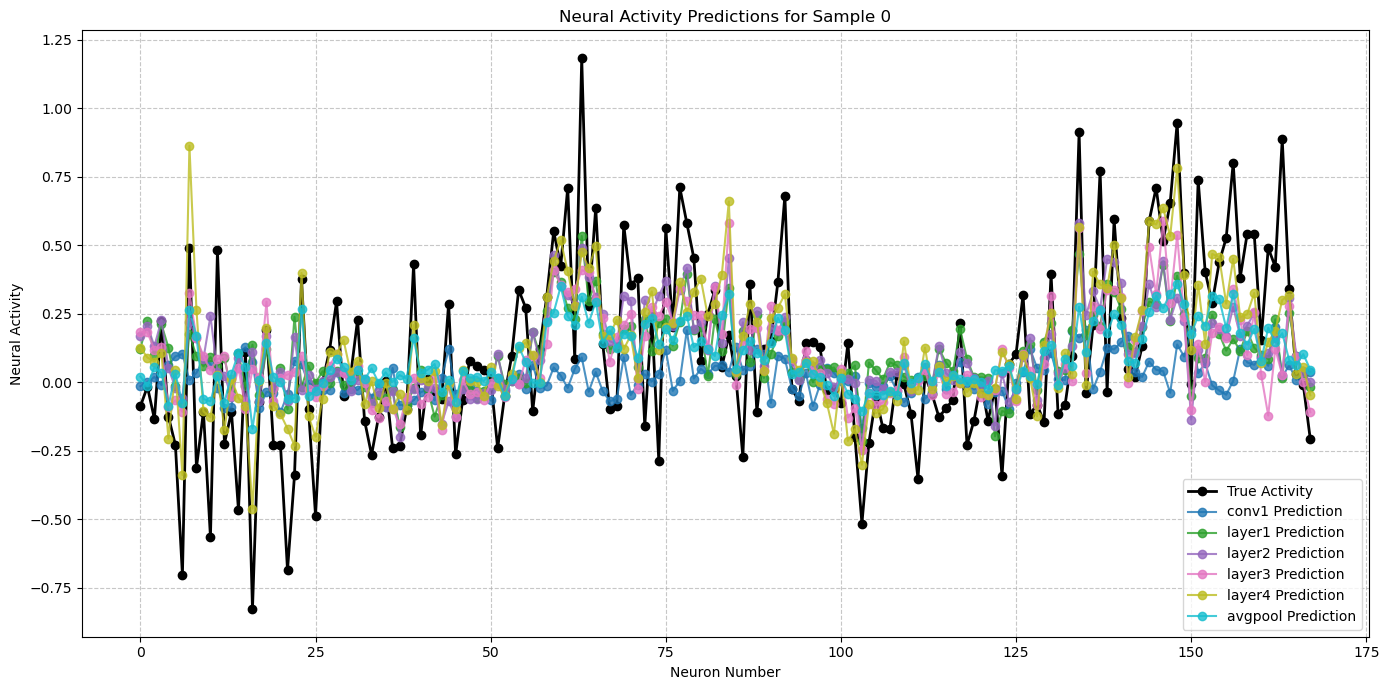

In [34]:
print("Predicting...")
layer_metrics = predict_neural_activity(pretrained_pcs_train, pretrained_pcs_val, y_train, y_val, regressor="Ridge", alpha=300000)

In [35]:
def plot_layer_metrics(my_model, layer_metrics, metric='exp_variances'):
    # Calculate mean metrics for each layer
    layers = layers_to_extract
    
    # Map metric parameter to the actual keys in the metrics dictionaries
    if metric == 'exp_variances' or metric == 'exp_variance':
        mean_key = 'mean_exp_variance'
        dist_key = 'exp_variances'
    elif metric == 'correlation':
        mean_key = 'mean_correlation'
        dist_key = 'correlations'
    else:
        mean_key = f'mean_{metric}'
        dist_key = metric
    
    # Prepare x-axis with layer names
    x = np.arange(len(layers))
    width = 0.35
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Get means for the model type
    model_means = [layer_metrics[layer][mean_key] for layer in layers]
    
    # Plot based on model type
    if my_model == "pretrained":
        plt.bar(x, model_means, width, label='Pre-trained')
    elif my_model == "random":
        plt.bar(x, model_means, width, label='Random')
    
    plt.xlabel('Network Layer')
    plt.ylabel('Mean ' + ('Correlation' if 'correlation' in metric else 'Explained Variance'))
    plt.title('Performance Across Layers')
    plt.xticks(x, layers, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

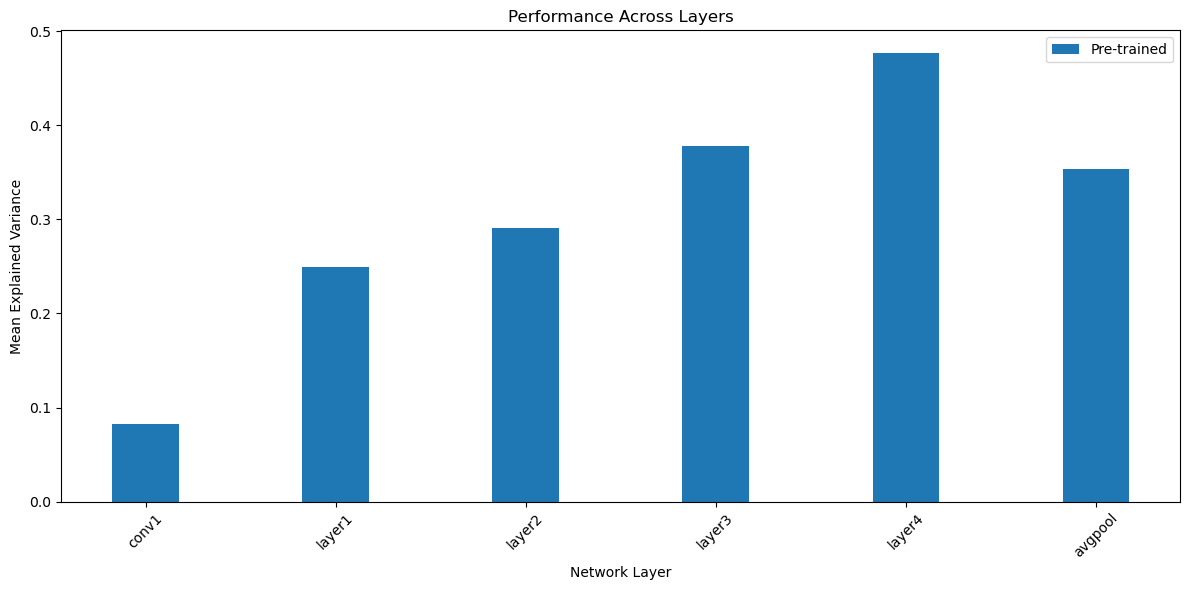

In [36]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='exp_variances')

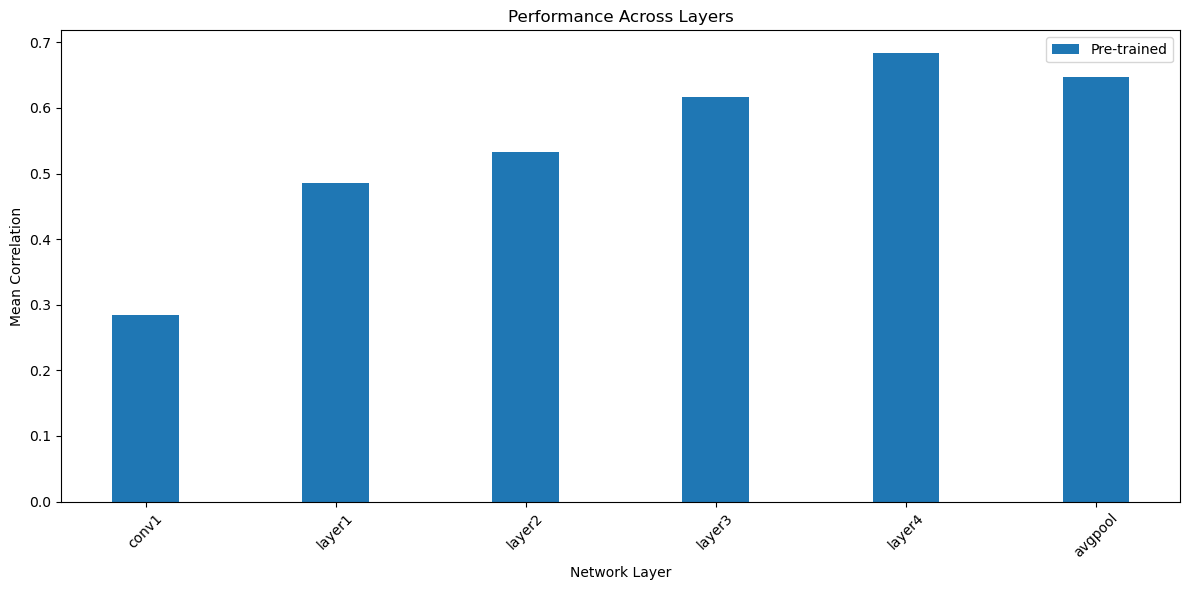

In [37]:
plot_layer_metrics(my_model, layer_metrics=layer_metrics, metric='correlation')

# 3 ... What if we use LORA

havnt finished

In [ ]:
# ! pip install peft

In [66]:
import torch
from peft import LoraConfig, get_peft_model
import torch.nn as nn
from torchvision.models import resnet50

In [67]:
model = resnet50(pretrained=True)
num_neurons = y_val.shape[1]
model.fc = nn.Linear(model.fc.in_features, num_neurons)

/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [69]:
target_modules = [
    # layer3
    "layer3.0.conv1", "layer3.0.conv2", "layer3.0.conv3",
    "layer3.1.conv1", "layer3.1.conv2", "layer3.1.conv3",
    "layer3.2.conv1", "layer3.2.conv2", "layer3.2.conv3",
    "layer3.3.conv1", "layer3.3.conv2", "layer3.3.conv3",
    "layer3.4.conv1", "layer3.4.conv2", "layer3.4.conv3",
    "layer3.5.conv1", "layer3.5.conv2", "layer3.5.conv3",
    
    # layer4
    "layer4.0.conv1", "layer4.0.conv2", "layer4.0.conv3",
    "layer4.1.conv1", "layer4.1.conv2", "layer4.1.conv3",
    "layer4.2.conv1", "layer4.2.conv2", "layer4.2.conv3",
    
    "fc"
]

In [74]:
lora_config = LoraConfig(
    r=16,                   # Rank of the LoRA matrix
    lora_alpha=32,          # Scaling parameter
    target_modules=target_modules,  # Layers to apply LoRA
    lora_dropout=0.1,       # Dropout rate
    bias="none",            # Whether to fine-tune bias
    task_type='FEATURE_EXTRACTION'         # emmm not exactly the same 
)

In [75]:
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 993,920 || all params: 24,846,184 || trainable%: 4.0003


In [76]:
optimizer = torch.optim.Adam(lora_model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [77]:
train_dataset = TensorDataset(
    torch.tensor(stimulus_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.tensor(stimulus_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [79]:
criterion = nn.MSELoss()

In [80]:
optimizer = optim.Adam(lora_model.parameters(), lr=1e-4)

In [82]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100)

In [83]:
num_epochs = 1000
best_correlation = 0.0

In [84]:
history = {
    'train_loss': [],
    'val_loss': [],
    'mean_correlation': [],
    'mean_exp_variance': []
}

In [87]:
class ResNetWrapper(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        self.resnet = resnet_model
    
    def forward(self, **kwargs):
        if 'pixel_values' in kwargs:
            inputs = kwargs['pixel_values']
        elif 'inputs_embeds' in kwargs:
            inputs = kwargs['inputs_embeds']
        else:
            inputs = kwargs.get('input_ids', None)
            

        assert input is not None, "No input found"
        return self.resnet(inputs)

In [88]:
model = resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_neurons)
wrapped_model = ResNetWrapper(model)

/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/askrbayern/miniforge3/envs/brainlike/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [89]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=target_modules,
    lora_dropout=0.1,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

lora_model = get_peft_model(wrapped_model, lora_config)

In [90]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, history, best_correlation):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train phase
        model.train()
        running_loss = 0.0
        
        with tqdm(train_loader, desc="Training") as pbar:
            for inputs, targets in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                
                outputs = model.forward(inputs)  # Using model.forward() instead of model()
                loss = criterion(outputs, targets)
                
                loss.backward()
                
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        train_loss = running_loss / len(train_loader)
        
        # Validation phase
        val_loss, mean_correlation, mean_exp_variance, correlations, exp_variances = validate(
            model, val_loader, criterion, device)
        
        # Adjust learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if mean_correlation > best_correlation:
            best_correlation = mean_correlation
            model.save_pretrained("best_lora_model")
            print(f"Saved best model, correlation: {best_correlation:.4f}")
        
        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['mean_correlation'].append(mean_correlation)
        history['mean_exp_variance'].append(mean_exp_variance)
        
        # Print results
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Mean Correlation: {mean_correlation:.4f}")
        print(f"Mean Explained Variance: {mean_exp_variance:.4f}")
    
    return best_correlation

In [91]:
best_correlation = train_and_validate(lora_model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, history, best_correlation)


Epoch 1/1000


Training:   0%|          | 0/81 [00:00<?, ?it/s]


TypeError: conv2d() received an invalid combination of arguments - got (NoneType, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!NoneType!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
